In [ ]:
%reset

In [14]:
import gpflow
import tensorflow as tf
import os
import numpy as np
import matplotlib.pyplot as plt
from gpflow.kernels import RationalQuadratic, Constant,Linear, White, Matern12, Matern32, Matern52, RBF, Cosine, Periodic


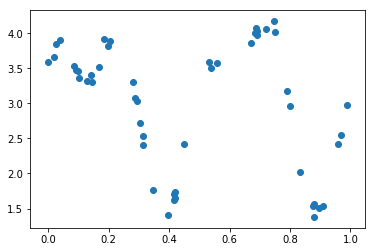

In [15]:
rng = np.random.RandomState(1)
N = 50
X = rng.rand(N,1)
Y = np.sin(12*X) + 0.66*np.cos(25*X) + rng.randn(N,1)*0.1 + 3

plt.scatter(X,Y)

In [16]:
with gpflow.defer_build():
    k = RationalQuadratic(1)# RBF(1)#+Cosine(1)#+Matern12(1)
    l = gpflow.likelihoods.Gaussian()
    m = gpflow.models.GPMC(X, Y, k,l)
    m.likelihood.variance = 0.01
#print(m)

In [17]:
def plot(m):
    xx = np.linspace(X.min(), X.max(), 100).reshape(100, 1)
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, 'kx', mew=2)
    plt.plot(xx, mean, 'C0', lw=2)
    plt.fill_between(xx[:,0],
                     mean[:,0] - 2*np.sqrt(var[:,0]),
                     mean[:,0] + 2*np.sqrt(var[:,0]),
                     color='C0', alpha=0.2)
    plt.xlim(-0.1, 1.1)




INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: -70.959583
  Number of iterations: 1001
  Number of functions evaluations: 1117


INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS EXCEEDS LIMIT'
  Objective function value: -70.959583
  Number of iterations: 1001
  Number of functions evaluations: 1117


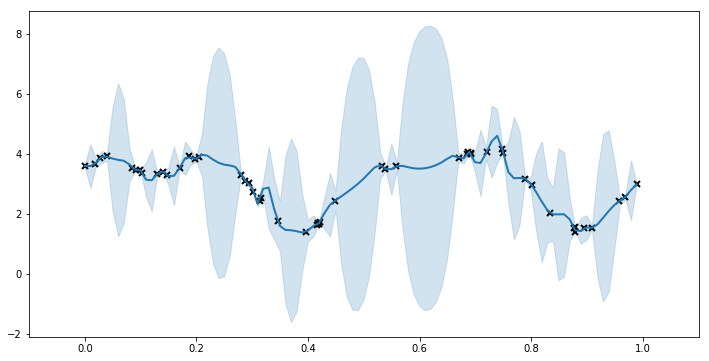

In [18]:
#MLE
m.compile()
gpflow.train.ScipyOptimizer().minimize(m)
m.as_pandas_table()
plot(m)


In [19]:
sampler = gpflow.train.HMC()
samples = sampler.sample(m, num_samples=gpflow.test_util.notebook_niter(500), epsilon=0.05, lmin=10, lmax=20, logprobs=False)


In [ ]:
xtest = np.linspace(-0.1,1.1,100)[:,None]
f_samples = []
for i, s in samples.iterrows():
    m.assign(s)
    f_samples.append(m.predict_f_samples(xtest, 5, initialize=False))
f_samples = np.vstack(f_samples)

In [ ]:
rate_samples = np.exp(f_samples[:, :, 0])

line, = plt.plot(xtest, np.mean(rate_samples, 0), lw=2)
plt.fill_between(xtest[:,0],
                 np.percentile(rate_samples, 5, axis=0),
                 np.percentile(rate_samples, 95, axis=0),
                 color=line.get_color(), alpha = 0.2)

plt.plot(X, Y, 'kx', mew=2)
plt.ylim(-0.1, np.max(np.percentile(rate_samples, 95, axis=0)))